# Notebook CURATOR for NeurIPS-AI4Mat
-------

*Xin Yang, Renata Sechi, Martin Hoffman Petersen, Arghya Bhowmik,  Heine H.Hansen*

Department of Energy Conversion and Storage, Technical University of Denmark, 2800 Kongens Lyngby, Denmark.

----
This notebook presents the functionality of CURATOR. You can find additional explanation in the [tutorial paper](https://openreview.net/forum?id=pKmcMaULn1&)
<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1).


For running this notebook you will need GPUs. Set the runtime type to **T4 GPU** from the menu bar Runtime &rarr; change runtime type.   

# Learning Objectives:
In this tutorial, you will learn how to:
________
1.   Set up the CURATOR workflow with its dependencies.
2.   Run the workflow.
3.   Understand the output structure and how to analyze it.
_______

In the following steps <a name="cite_ref-a"></a>[<sup>[a]</sup>](#cite_note-a), we set up the dependencies of the code in all its steps.

<a name="cite_note-a"></a>[<sup>[a]](#cite_ref-a)  For clarity reasons, we are hiding the output of some cells with the command `%%capture`. Surely, you can delete this command if you prefer to read the output or for debugging purposes.  


# GPAW

For the the DFT labeling step, we use [GPAW](https://wiki.fysik.dtu.dk/gpaw/), a DFT Python code <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2).

In [ ]:
! git clone -b 23.9.1 https://gitlab.com/gpaw/gpaw.git gpawgit #remove directory in case you run multiple times without restarting the kernel

In [ ]:
%%capture
! apt-get update

In [ ]:
%%capture
!apt-get install libxc-dev libopenblas64-serial-dev libblas-dev libscalapack-mpi-dev libfftw3-dev tree

In [ ]:
%%capture
!pip install -e gpawgit/

We download some datasets needed for the calculations. You can go on the  [GPAW webpage](https://wiki.fysik.dtu.dk/gpaw/install.html#install-paw-datasets) for more information on GPAW's setup.

When you run the cell for the datasets, it will ask you if you want to register the current path as setup path for GPAW. You should answer yes by typing `y` next to the question.


In [ ]:
! mkdir '/content/gpaw_setups'
! gpaw install-data '/content/gpaw_setups'

Once installed GPAW, we need to restart the runtime. For doing this, you just need to run the cell below. Else, you can just restart the runtime from the menu bar.

In [ ]:
# now restart runtime from the runtime menu and run the rest
import os
os.kill(os.getpid(), 9)

We can now check that your GPAW installation is working.

In [ ]:
from gpaw import GPAW
from ase.io import read


We can now print some information about the GPAW and its dependencies.

In [ ]:
!gpaw info



---

# CURATOR: Autonomous Batch Active-Learning Workflow for Catalysts

---

Here we go! Now we will install Curator.
You already have all the scripts and the codes, but we need to install some packages to be ready to run the workflow.

In [ ]:
! pip install toml

Now you need to install PyTorch. Since there are many options, here is how you get to install the correct one for your resources.  The output will show you your CUDA and Python version, which you will use in for knowing which version of PyTorch to install.

In [ ]:
!nvcc --version
!python --version

Check the version of NVIDIA and Python to download PyTorch from its website
( https://pytorch.org/get-started/locally/)
After selecting the parameters, you will get a line of code you can simply copy and run. Here is ours:  



In [ ]:
%%capture
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
%%capture
! pip install asap3

Now we will install [MyQueue](https://myqueue.readthedocs.io/en/latest/), a fronted that we will use for managing the tasks of our workflow <a name="cite_ref-3"></a>[<sup>[3]</sup>](#cite_note-3).

In [ ]:
#myqueue
! pip install myqueue==22.7.1

We need that the notebook has access to the files in the directory; this can be done my mounting the content of your Google Drive. Once you run the cell below, a popup will appear asking you if you want allow to connect.

Of course, if you are running on your machine, you can skip this step.

In [ ]:
#now install the package
from google.colab import drive
drive.mount('/content/drive')

We change the directory so that we can spare ourselves to write the whole path each time. This is optional, but we strongly recommend to do it (it also prevents some bug due to misspelling).

In [ ]:
import os
#change the directory loacation depending on your path
os.chdir('/content/drive/MyDriveyour-path-to/tutorial-video/')
! ls

We initiate MyQueue. The first line of the code creates a  directory `.myqueue`, in which we will write a configuration file `config.py`.

This file contains the configuration of your resources. In this case, we want to use the local scheduler, but if you are working with a HPC you might want ot add the names of your nodes etc.







In [ ]:
!mq init
!mq config #guess configuration

In [ ]:
#write a file with the configuration
with open(".myqueue/config.py", 'w') as file:

    file.write("config = {'scheduler': 'local'}")

MyQueue generates some files that you may want to delete for restarting the workflow. If this is the case, you can run the following cell.

In [ ]:
os.listdir('.myqueue')
#remove files other than the configuration one
for p in os.listdir('.myqueue'):
  if p != 'config.py':
    os.remove(f'.myqueue/{p}')



---

#                                 Run the workflow

---



Now everything is ready to run CURATOR!
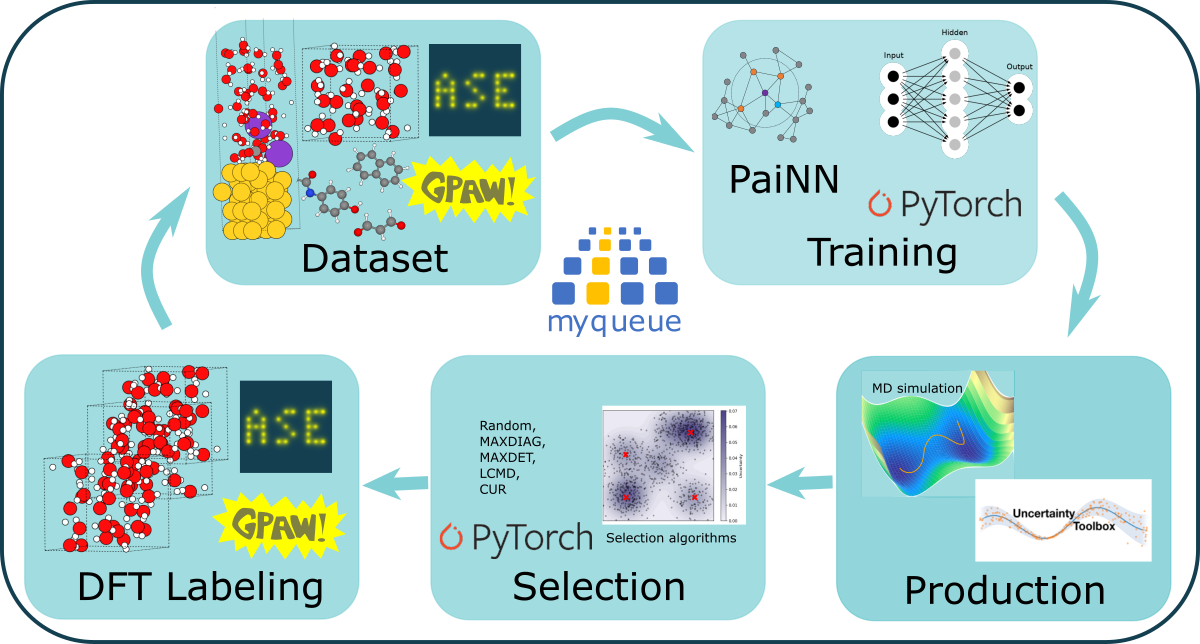

Before running, we should have a look at the structure of the files. There are some Python files that we need in this directory to set up the characteristics of the workflow and some TOML files.

In the TOML files, we add the parameters for each step of the workflow. You can open the `config.toml` and check the ones we chosed for this demo. When running with another trajectory, you should first edit the files parameters. \\
There is also another file, called `labeling_config.toml`, in which we set the parameters needed for the DFT labeling. Here, it is set for GPAW; however, it is possible to use the workflow also with VASP.  \\
You will find also another directory called PaiNN, with the code of the PaiNN model <a name="cite_ref-4"></a>[<sup>[4]</sup>](#cite_note-4).

## It is important that you change the path to your training file in the `config.toml` file!

You can access to this file from the folder icon on your left. Just navigate to your current directory for the tutorial and change the path for the location of the trajectory file in the config.toml.

In [ ]:
! tree -L 2


For this tutorial, we are running the workflow in local.

The first command you will run is for the `PYTHONPATH`, so that all the jobs can load all the necessary modules.

The second part is the command for running the `MyQueue` in local.

The third part is nothung but `mq workflow flow.py --force -T`.
*  `--force` submit also failed workflow tasks. It is not needed if you run the workflow once, but it is faster to have it already there in case
something crashes and you want to restart the workflow.
*   `-T` is just for tracing errors, in case the submission is not successful.  

In [ ]:
import os
import subprocess
from rich import print
env = os.environ.copy()

ppath = ''
if 'PYTHONPATH' in env.keys():
  ppath = env['PYTHONPATH']
env['PYTHONPATH'] = f'{os.getcwd()}:{ppath}'
print(env['PYTHONPATH'])
try:
  mq_local_server = subprocess.Popen(['python3', '-m', 'myqueue.local'],
                                    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, env=env) # The subprocess for running myqueue local server
  # The process for running the workflow
  mq_workflow = subprocess.run(['mq', 'workflow', 'flow.py' , '--force', '-T'],
                              stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env)
  print(mq_workflow.stdout)
except Exception as e:
  print(e)
else:
  mq_ls = subprocess.run(['mq', 'ls'],
                         stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
  print(mq_ls.stdout)
#

In case something crashes, or you want to remove some files, you can run the cell below. For the complete documentation of the commands, please refer to the [MyQueue documentation](https://myqueue.readthedocs.io/en/latest/documentation.html).

In [ ]:
#!mq remove -s rFCd -r .

You can monitor the progress of your workflow by running the cell below.

In [ ]:
! mq ls

Once done or meanwhile you are running the tasks, you can try to run the tree command again and check the structure of the workflow output.

In [ ]:
! tree . --dirsfirst -L 2

Now you can analyze your results.For example, you can plot the temperature of the simulation or visualize the MD trajectory generated by the MLIP.

In [ ]:
%%capture
!   pip install nglview


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from ase.visualize import view
from ase.io import Trajectory

md_i0 = Trajectory('md/iter_0/water/MD.traj')
view(md_i0, viewer='ngl')

----------
# On a HPC
----------



*   Install the required packages
*   Configure MyQueue for your HPC resources (see examples in the MyQueue documentation)
*   Modify your `config.toml` accordingly to your paths (and your computational resources)
*   Go in your directory and run `mq workflow flow.py`

This will generate an output like:

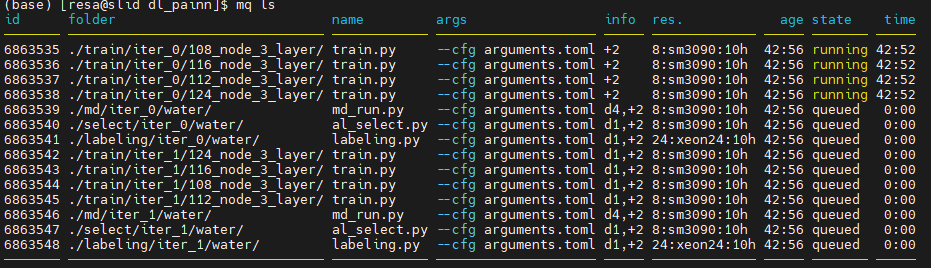

The directory structure stays the same as the one for this notebook; however, the configuration of the MyQueue scheduler will be different. In the screenshot, for example, it is for *Niflheim* Linux cluster at the Technical University of Denmark.


# References

<a name="cite_note-1"></a>[<sup>[1]](#cite_ref-1) Yang et al., (2023). CURATOR: Autonomous Batch Active-Learning Workflow for Catalysts. AI for Accelerated Materials Design-NeurIPS 2023 Workshop.

<a name="cite_note-2"></a>[<sup>[2]](#cite_ref-2) J. Enkovaara et al.- (2010). Electronic structure calculations with GPAW: a real-space implementation of the projector augmented-wave method. J. Phys.: Condens. Matter 22, 253202.

<a name="cite_note-3"></a>[<sup>[3]](#cite_ref-3)  Mortensen et al., (2020). MyQueue: Task and workflow scheduling system. Journal of Open Source Software, 5(45), 1844.

<a name="cite_note-4"></a>[<sup>[4]](#cite_ref-4) Schütt el al.,  (2021). Equivariant message passing for the prediction of tensorial properties and molecular spectra. Proceedings of the 38th International Conference on Machine Learning, PMLR 139, 9377-9388.

*Thanks to Steen Lysgaard and Pooria Dabbaghi for the help in setting up this notebook.*